In [ ]:
# @title Imports (run this cell)
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Instructions for updating:
non-resource variables are not supported in the long term


Installing Altair...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-583mrq7b
  Running command git clone --filter=blob:none --quiet git://github.com/altair-viz/altair.git /tmp/pip-req-build-583mrq7b
  fatal: unable to connect to github.com:
  github.com[0: 20.205.243.166]: errno=Connection timed out

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet git://github.com/altair-viz/altair.git /tmp/pip-req-build-583mrq7b did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet git://github.com/altair-viz/altair.git /tmp/pip-req-build-583mrq7b did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and

In [ ]:
%cd /content/drive/MyDrive/KDD2023

/content/drive/MyDrive/KDD2023


In [ ]:
df1 = pd.read_csv("sessions_train.csv")

In [ ]:
df2 = pd.read_csv("sessions_test_task1.csv")

In [ ]:
df1 = df1[df1["locale"].isin(df2["locale"].unique())].reset_index(drop=True)

In [ ]:
df1 = df1[df1["locale"]=="DE"].drop(columns=["locale"])
df2 = df2[df2["locale"]=="DE"].drop(columns=["locale"])

In [ ]:
movies = pd.read_csv("products_train.csv")
movies = movies[movies["locale"]=="DE"].reset_index().rename(columns={"id":"movie_id"})

In [ ]:
movies.head(2)

,index,movie_id,locale,title,price,brand,color,size,model,material,author,desc
0,0,B005ZSSN10,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.950,RED DRAGON,NaN,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...
1,1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.900,Simply Keto,NaN,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Crear el objeto LabelEncoder
encoder = LabelEncoder()
encoder = encoder.fit(movies["movie_id"])

In [ ]:
movies["movie_id"] = encoder.transform(movies["movie_id"])
movies.head(5)

,index,movie_id,locale,title,price,brand,color,size,model,material,author,desc
0,0,37789,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.950,RED DRAGON,NaN,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...
1,1,292395,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.900,Simply Keto,NaN,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...
2,2,395592,DE,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",68.890,Sennheiser,Multi-Colour,One size,508377,Kunstleder,NaN,3.5 MM BUCHSE - Kann problemlos an Geräte mit ...
3,3,318099,DE,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,18.990,Amy & Benton,Animal Car,NaN,2008B,aufziehauto 1 jahr,NaN,【Auto aufziehbar】: Drücken Sie einfach leicht ...
4,4,330713,DE,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,7.170,PLAYMOBIL,Nicht Zutreffend.,OneSize,70522,Polypropylen,NaN,Inhalt: 1 Stück


In [ ]:
import pandas as pd
from tqdm import tqdm



In [ ]:
# Función para reorganizar el DataFrame
def reformat_dataframe(aux_df, train=True):
    import pandas as pd
    import re
    df = aux_df.copy()
    # Convertir las cadenas en matrices de NumPy
    df["prev_items"] = df["prev_items"].apply(lambda x: re.findall(r"'([^']*)'", x))
    session_id_col = []
    item_id_col = []
    time_col = []

    for i, row in df.iterrows():
        session_id = i
        for j, item_id in enumerate(row["prev_items"]):
            session_id_col.append(session_id)
            item_id_col.append(item_id)
            time_col.append(j)  
        if train:
            session_id_col.append(session_id)
            item_id_col.append(row["next_item"])
            time_col.append(len(row["prev_items"]))
    new_df = pd.DataFrame({"SessionId": session_id_col, "ItemId": item_id_col, "Time": time_col})
    return new_df


In [ ]:
ratings = reformat_dataframe(df1)

In [ ]:
ratings = ratings[["SessionId","ItemId"]].drop_duplicates()

In [ ]:
ratings.shape

(5211363, 2)

In [ ]:
ratings = ratings.rename(columns={"SessionId":"user_id"})

In [ ]:
ratings["movie_id"] = encoder.transform(ratings["ItemId"]).astype(str)

In [ ]:
rated_movies = (ratings[["user_id", "movie_id"]]
                .groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))

In [ ]:
ratings["movie_id"][0]

'435315'

In [ ]:
movies["movie_id"] = movies["movie_id"].astype(str)

In [ ]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [ ]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [ ]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [ ]:
#@title Solution
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

In [ ]:
ratings["rating"]=5

In [ ]:
users = ratings["user_id"].drop_duplicates()

 iteration 6000: train_error=2.322233, test_error=29.878160

[{'train_error': 2.3222332, 'test_error': 29.87816}]

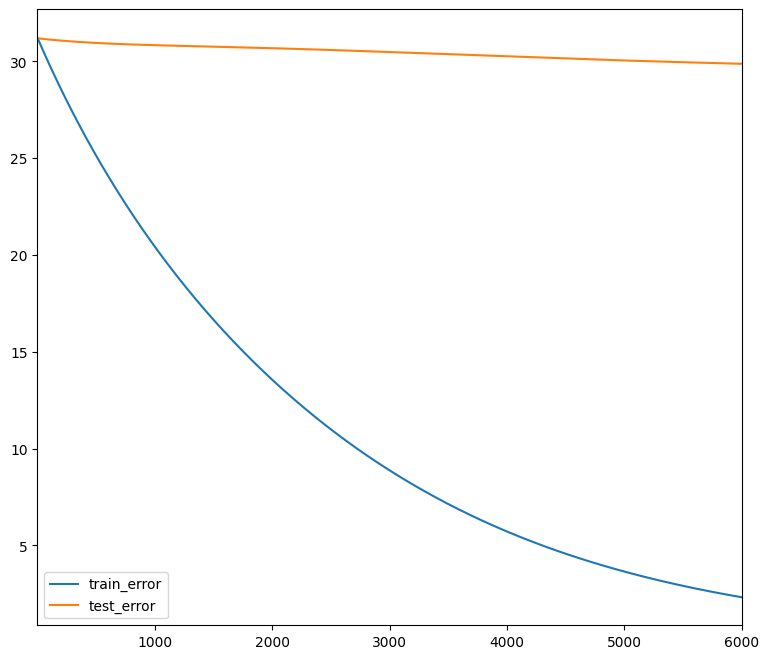

In [ ]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=100, init_stddev=0.5)
model.train(num_iterations=6000, learning_rate=10.)

 iteration 600000: train_error=0.000001, test_error=29.284885

[{'train_error': 6.241207e-07, 'test_error': 29.284885}]

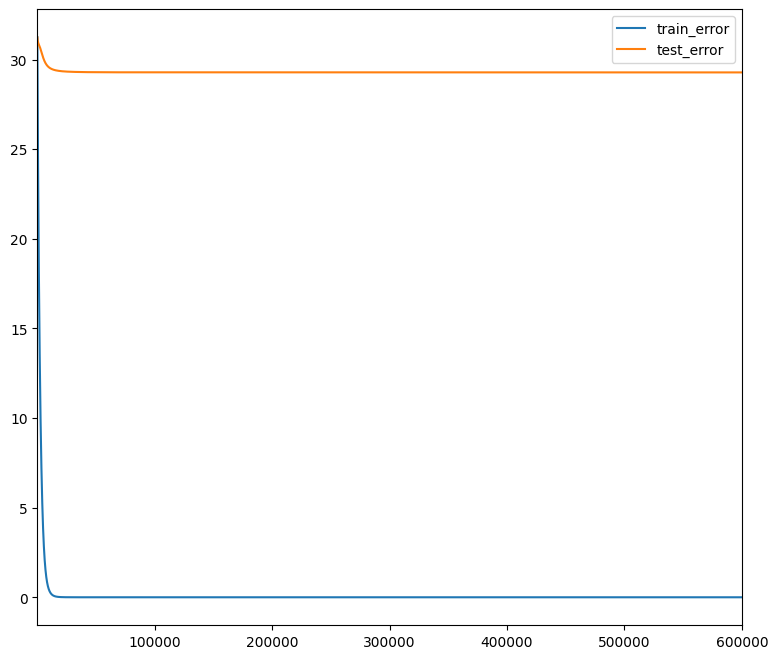

In [ ]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=100, init_stddev=0.5)
model.train(num_iterations=600000, learning_rate=10.)

In [ ]:
 df_emb = pd.DataFrame(model.embeddings["movie_id"])

In [ ]:
df_aux = ratings.sort_values(["movie_id"])

In [ ]:
df_aux2 = df_aux[["ItemId","movie_id"]].drop_duplicates().reset_index(drop=True)

In [ ]:
df_emb["movie_id"] = df_emb.index.astype(str)

In [ ]:
df_para_dani = pd.merge(df_aux2[["ItemId","movie_id"]], df_emb, how="inner", on="movie_id")

In [ ]:
df_para_dani.to_csv("Primeros_embeddings.csv",index=False)

In [ ]:

def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))